# Part 10 of Recipes: ID Fields

This page is primarily based on the following page at the Circos documentation site:



- [10. ID Fields](????????????)



That page is found as part number 4 of the ??? part ['Recipes' section](http://circos.ca/documentation/tutorials/quick_start/) of [the larger set of Circos tutorials](http://circos.ca/documentation/tutorials/).



Go back to Part 9 by clicking [here &#8592;](Recipes_Part9.ipynb).



----



8 --- Recipes
=============

10. ID Fields
-------------

::: {#menu4}
[[Lesson](/documentation/tutorials/recipes/data_id/lesson){.clean}]{.active}
[Images](/documentation/tutorials/recipes/data_id/images){.normal}
[Configuration](/documentation/tutorials/recipes/data_id/configuration){.normal}
:::

In this tutorial, I will demonstrate how to apply formatting to data
based on its identifier stored in the `id` field.

As you\'ve seen, each data point can have values set for format
parameters such as `color`, `stroke_thickness`, `fill_color`, and so on.
These elements can be defined in (a) the data file itself, independently
for each data point (b) in rule blocks or (c) as global settings for the
entire data set.

However, it may be convenient to assign an annotation to your data
points and then calculate format values based on the annotation. This is
where the `id` field is useful---this field does not directly impact the
way the data point is displayed, but tags it with a string which you can
use in rule blocks.

### Formatting Tiles

In the first example, I\'ll show you how to dynamically format tiles.

There is a variety of repeat element types (LINE, SINE, Satellite,
simple, etc) and these may be stored as follows

```ini
...
chr21 30003462 30003712 AluSx SINE Alu
chr21 30003734 30003925 L1MD LINE L1
chr21 30004082 30004207 L1ME4a LINE L1
chr21 30004229 30004286 AT_rich Low_complexity Low_complexity
chr21 30004378 30004615 L1ME4a LINE L1
chr21 30004781 30004872 AT_rich Low_complexity Low_complexity
chr21 30004942 30005099 CT-rich Low_complexity Low_complexity
chr21 30005358 30005634 MER7A DNA MER2_type
chr21 30006113 30006265 L1ME4a LINE L1
...
```


with each element having multiple, independent classifications (e.g.
AluSx, SINE, Alu). To use these classifications, you will need to parse
the data and associate a `id` parameter with each data point. The value
of the `id` parameter is up to you. I used this script

```ini
#!/usr/bin/perl
use strict;
$,=" ";
$\="\n";
while(<>) {
chomp;
my $id;
s/chr/hs/;
if(/L(\d+)/) {
$id = "LINE$1";
} elsif (/S(\d+)/ || /SINE(\d?)/) {
#my $num = $1 || 0;
$id = "SINE" . ($1||0);
} elsif (/low/i || /simple/i) {
$id = "SIMPLE";
} elsif (/LTR/) {
$id = "LTR";
} else {
$id = "OTHER";
}
my @tok = split;
print @tok[0..2],"id=$id";
}
```


to transform the data file above into the following

```ini
...
hs21 30003462 30003712 id=SINE0
hs21 30003734 30003925 id=LINE1
hs21 30004082 30004207 id=LINE1
hs21 30004229 30004286 id=SIMPLE
hs21 30004378 30004615 id=LINE1
hs21 30004781 30004872 id=SIMPLE
hs21 30004942 30005099 id=SIMPLE
hs21 30005358 30005634 id=OTHER
hs21 30006113 30006265 id=LINE1
...
```


Define a tile block to show these elements

```ini
<plot>
type = tile
file = repeats.withid.txt
r0   = 0.8r
r1   = 0.98r
orientation = in
layers      = 50
thickness   = 20p
padding     = 6p
margin      = 0.001u
color       = black
# for very small tiles a stroke is useful because
# it ensures that tiles associated with very small
# spans will be visible
stroke_thickness = 2p
stroke_color = black
```


```ini
# RULES WILL GO HERE
```


```ini
</plot>
```


With this block, all repeat tiles will have the same formatting. To
apply formatting specific to `id` values, use

```ini
# test with regular expression
condition = var(id) =~ /LINE/
```


or

```ini
# test string equality
condition = var(id) eq "LINE"
```


For example, this set of rules applies different formatting to elements
with `id` LINE, SINE, SIMPLE and OTHER. For LINE elements, fill color is
set to green, but LINE1 and LINE2 elements have an additional
stroke\_color condition.

```ini
<plot>
```


```ini
...
```


```ini
<rules>
```


```ini
<rule>
condition    = var(id) =~ /LINE/
color        = green
flow         = continue
</rule>
```


```ini
<rule>
condition    = var(id) =~ /LINE[12]/
stroke_color = red
</rule>
```


```ini
<rule>
condition    = var(id) =~ /SINE/
color        = blue
stroke_color = blue
</rule>
```


```ini
<rule>
condition    = var(id) =~ /SIMPLE/
color        = dgrey
</rule>
```


```ini
<rule>
condition    = var(id) =~ /OTHER/
color        = lgrey
</rule>
```


```ini
</rules>
```


```ini
</plot>
```


The first rule makes use of the `flow=continue` directive, which
prevents the rule chain from terminating if this rule matches. This
allows a rule for LINE and another rule for the more specific LINE1 or
LINE2 test. To read more about rule flow, see [Basic Rules
Tutorial](/documentation/tutorials/links/rules1).

### Formatting Links

Let\'s look how link formatting can be adjusted in the same way.

Suppose you have links which have an `id` field that contains your
annotation. In this example, I use an annotation in the format
`number-number` (e.g. 87-69). This format is arbitrary and will serve to
show how regular expressions in rules can be used to extract values.

```ini
...
linkid5 hs21 30772491 30777591 id=87-69
linkid5 hs21 30602230 30607330 id=87-69
linkid6 hs21 30257977 30263077 id=60-22
linkid6 hs21 30367808 30372908 id=60-22
linkid7 hs21 30079003 30084103 id=54-90
linkid7 hs21 30771970 30777070 id=54-90
...
```


We will first set the thickness of the link based on the first number in
the `id` field.

```ini
<rule>
# make sure that the id field matches the required number-number format
condition  = var(id) =~ /(\d+)-(\d+)/
# extract the two number in 'id' to @match and use remap() function to map
# the first number in the range 1..100 to thickess in the range 1..10.
thickness  = eval( my @match = var(id) =~ /(\d+)-(\d+)/; remap($match[0],1,100,1,10) )
# so that other rules can trigger too
flow = continue
</rule>
```


Let expand the rule to remap the z-value (depth), color and transparency
as well.

```ini
<rule>
# make sure that the id field matches the required number-number format
condition  = var(id) =~ /(\d+)-(\d+)/
# extract the two number in 'id' to @match and use remap_int() function to map
# the first number in the range 1..100 to integer thickess in the range 1..10.
thickness  = eval( my @match = "var(id)" =~ /(\d+)-(\d+)/; remap_int($match[0],1,100,1,10) )
```


```ini
# use the first number as the z-value (i.e. thick links will be drawn on top)
z          = eval( my @match = "var(id)" =~ /(\d+)-(\d+)/; $match_int[0] )
```


```ini
# use the second number for the color and transparency
color      = eval( my @match = "var(id)" =~ /(\d+)-(\d+)/;  
sprintf("spectral-9-div-%d_a%d", remap_int($match[1],1,100,1,9),  
remap_int($match[1],1,100,5,1 ) ) )
</rule>
```


Notice that the `id` field, which is text, is set in quotes. This is
required so that the Perl expression for evaluation is

```ini
# correct - "87-69" treated as string
my @match = "87-69" =~ /(\d+)-(\d+)/
```


rather than

```ini
# incorrect - 87-69 treated as literal
my @match = 87-69 =~ /(\d+)-(\d+)/
```


Remember that you can use `-debug_group rules` as a command-line
parameter when running Circos to obtain debug information about how
rules are parsed.

### Formatting Text

To format text labels based on the `id` field the recipe is the same. If
your text data looks like this

```ini
...
hs21 30829740 30829740 tb id=64
hs21 30405360 30405360 oe id=31
hs21 30112849 30112849 ps id=74
hs21 30721834 30721834 dg id=25
hs21 30325022 30325022 sj id=22
...
```


then the rules to change the color and label size based on the `id`
field would be

```ini
<rule>
condition  = 1
color      = eval(sprintf("set2-4-qual-%d",remap_int(var(id),1,100,1,4)))
label_size = eval(sprintf("%dp",remap_int(var(id),1,100,12,48)))
</rule>
```


In this case, I\'ve set `condition=1` to apply the rule without checking
that the `id` field matches the right format. Also, the `id` string does
not require quotes because the value of the parameter is a number, which
does not need to be quoted (quoting it won\'t hurt, though).




----

### Generating the plot produced by this example code


The following two cells will generate the plot. The first cell adjusts the current working directory.

In [1]:
%cd ../circos-tutorials-0.67/tutorials/8/10/

/home/jovyan/circos-tutorials-0.67/tutorials/8/10


In [2]:
%%bash
../../../../circos-0.69-6/bin/circos -conf circos.conf

debuggroup summary 0.33s welcome to circos v0.69-6 31 July 2017 on Perl 5.022000
debuggroup summary 0.34s current working directory /home/jovyan/circos-tutorials-0.67/tutorials/8/10
debuggroup summary 0.34s command ../../../../circos-0.69-6/bin/circos -conf circos.conf
debuggroup summary 0.34s loading configuration from file circos.conf
debuggroup summary 0.34s found conf file circos.conf
debuggroup summary 0.59s debug will appear for these features: output,summary
debuggroup summary 0.59s bitmap output image ./circos.png
debuggroup summary 0.59s SVG output image ./circos.svg
debuggroup summary 0.59s parsing karyotype and organizing ideograms
debuggroup summary 0.79s karyotype has 24 chromosomes of total size 3,095,677,436
debuggroup summary 0.79s applying global and local scaling
debuggroup summary 0.80s allocating image, colors and brushes
debuggroup summary 2.85s drawing 1 ideograms of total size 1,020,000
debuggroup summary 2.85s drawing highlights and ideograms
debuggroup summary 

Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781, <F> line 100.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781, <F> line 1896.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.


View the plot in this page using the following cell.

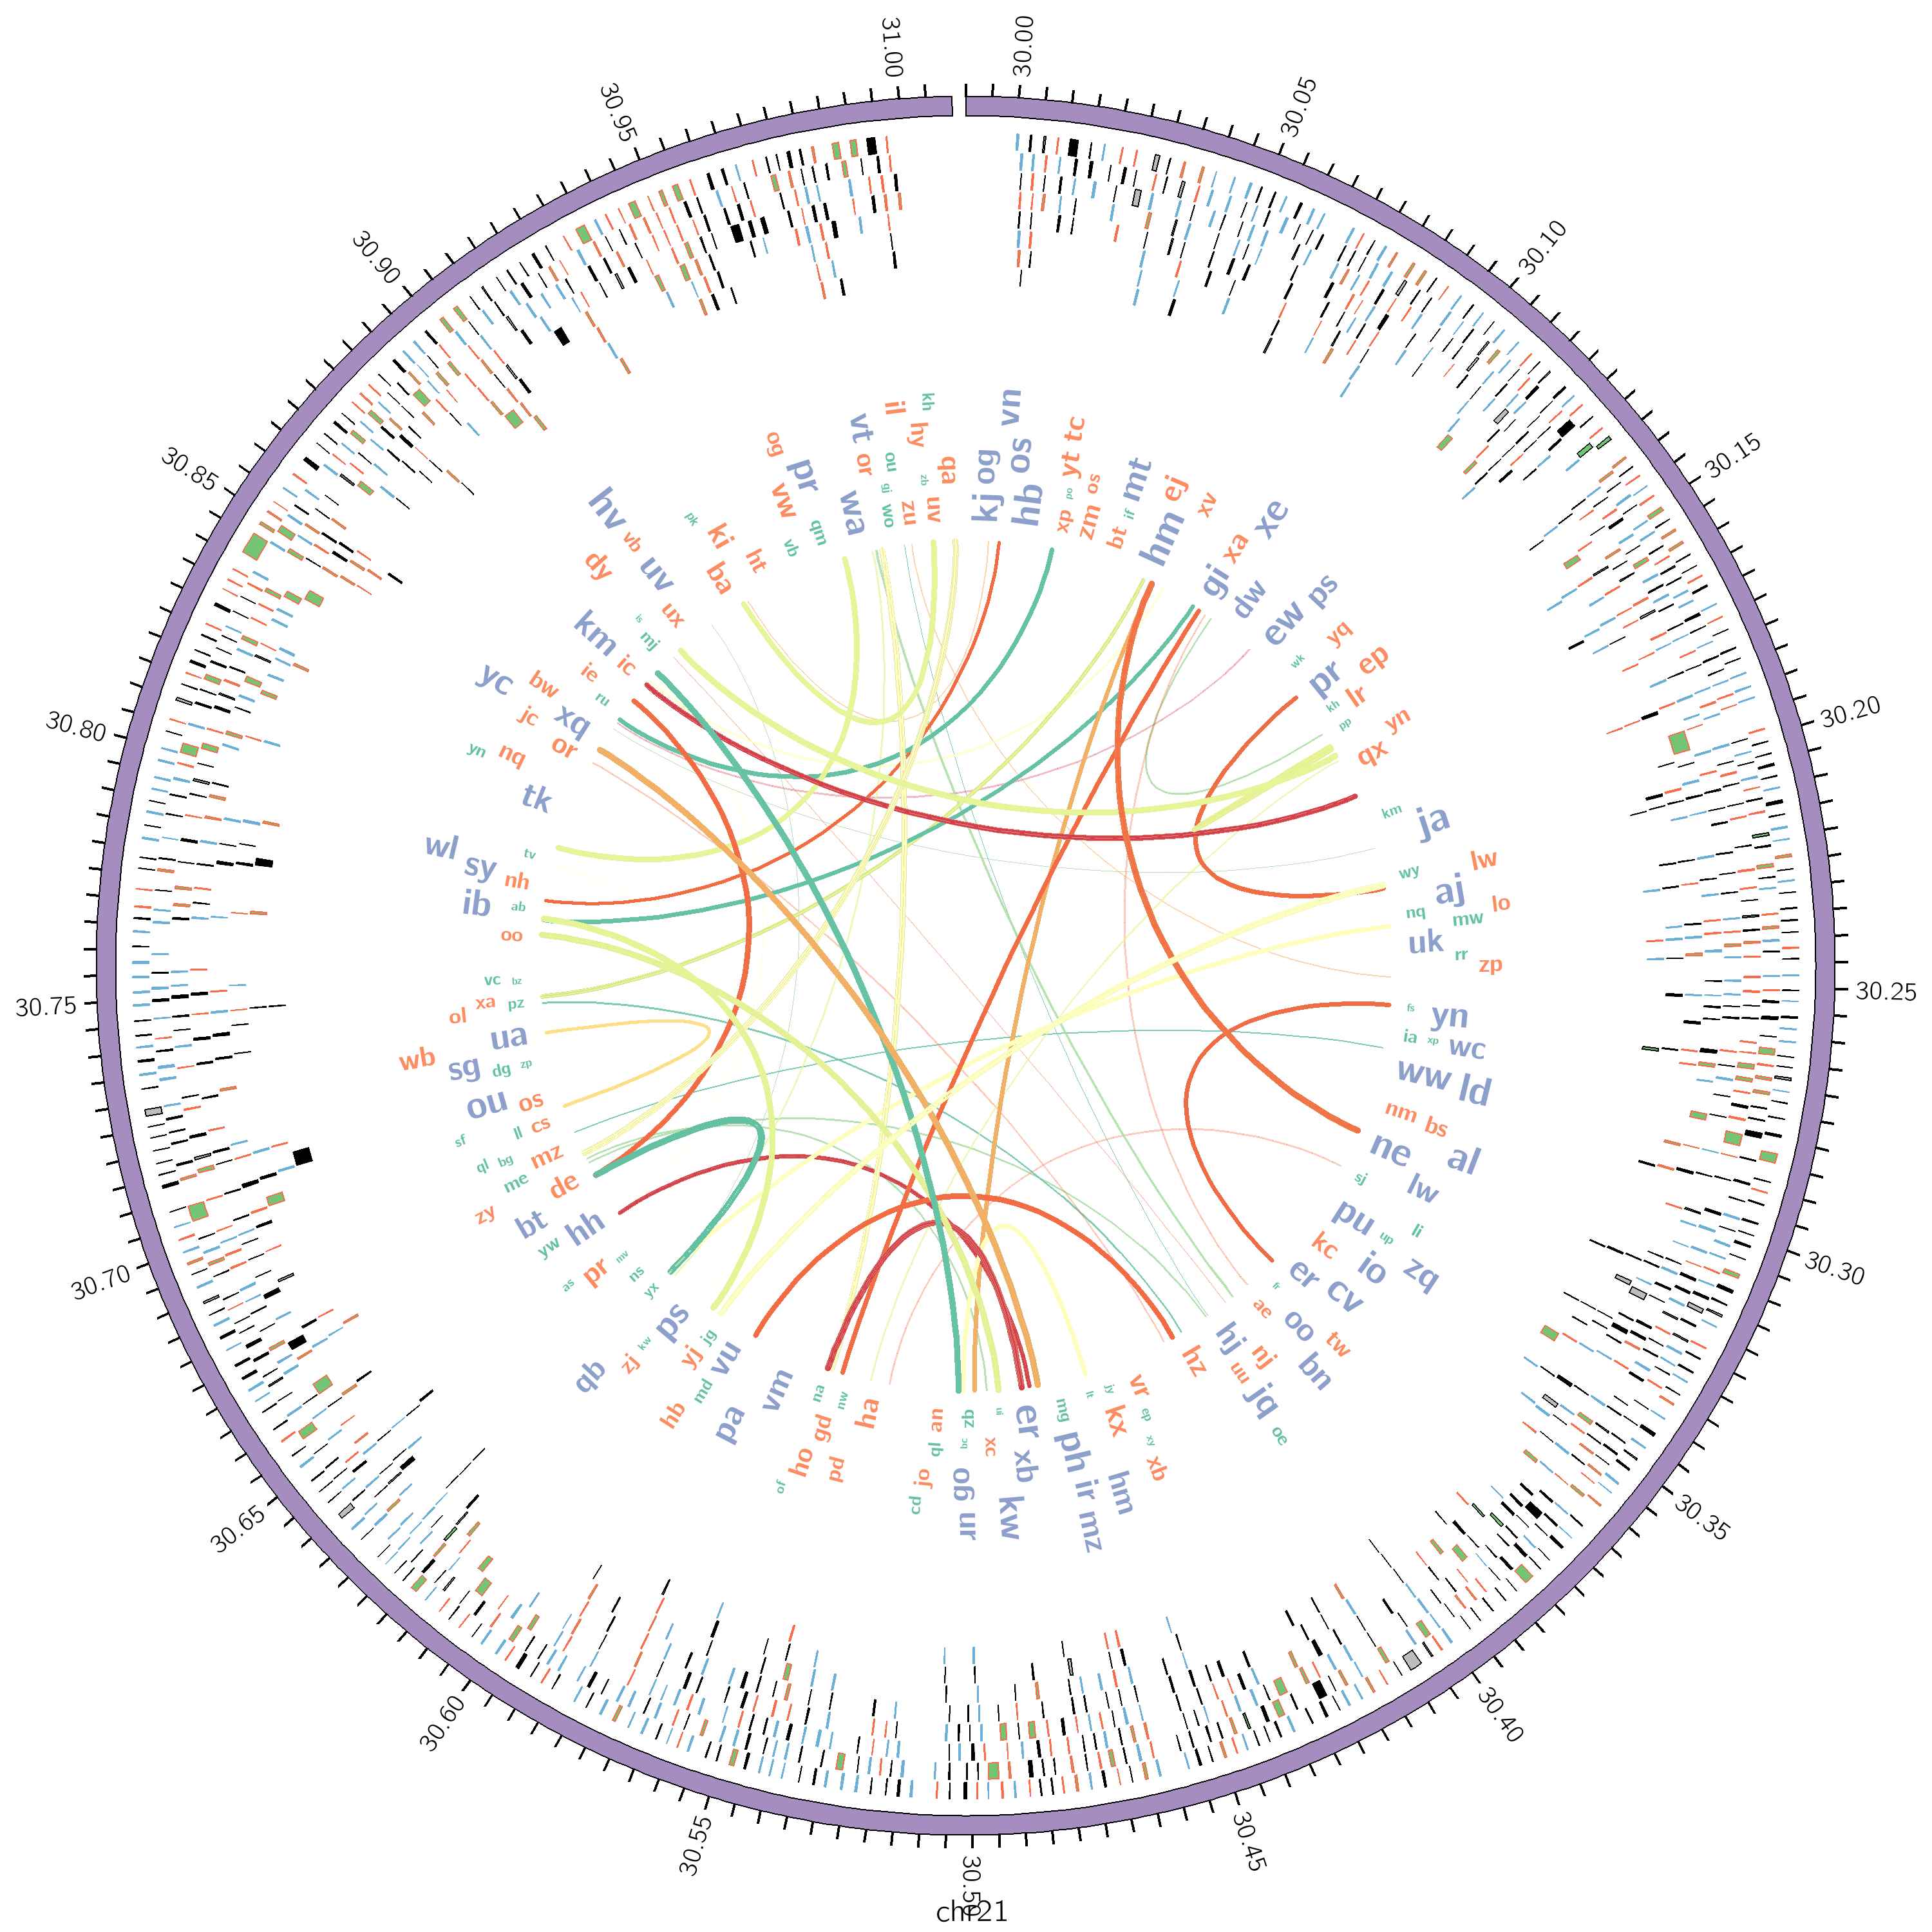

In [3]:
from IPython.display import Image
Image("circos.png")

----

Continue on to the next part of the Recipes series by clicking [here &#10145;](Recipes_Part11.ipynb).

----